# Visualizing the manually-curated data
In this notebook, we load some manually-curated data on papers using Diversity Statements, and visualize various aspects of this data.

In [1]:
#!usr/bin/bash/python3

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib_venn import venn3_circles, venn3_unweighted
from matplotlib_venn import _common, _venn3
import matplotlib
import re

%matplotlib inline

## Load the data
This data was gathered manually from a Google Scholar search for the papers that cite the preprint on this topic: 

Dworkin, J. D., Linn, K. A., Teich, E. G., Zurn, P., Shinohara, R. T., & Bassett, D. S. (2020). The extent and drivers of gender imbalance in neuroscience reference lists. arXiv preprint arXiv:2001.01002.

In [2]:
datafile = '../../data/citing_papers__manually_gathered.csv'
df = pd.read_csv(datafile)
print('Data columns: ', list(df.columns))
df.head(2)

Data columns:  ['paper_opencitations', 'code_opencitations', 'paper_googlescholar', 'code_googlescholar', 'title', 'bassett_author', 'arxiv', 'doi', 'preprint', 'paper_citation', 'code_citation', 'diversity_statement', 'ds_text']


,paper_opencitations,code_opencitations,paper_googlescholar,code_googlescholar,title,bassett_author,arxiv,doi,preprint,paper_citation,code_citation,diversity_statement,ds_text
0,0,0,1,1,Temporal sequences of brain activity at rest a...,1,0,10.1038/s42003-020-0961-x,0,1,1,1,Recent work in neuroscience85and otherfields86...
1,0,0,1,0,Models of communication and control for brain ...,1,arXiv:2002.07029,0,1,1,1,1,Recent work in neuroscience and other fields h...


## Looking at features of papers that might help us find them automatically
Here, we look at whether papers contain a diversity statement, and whether they cite the code and/or the original paper. This way, we can get an idea of how to make an automatic search that would find all relevant papers. 

In [3]:
def venn_of_df(df, labels):
    subsets = []
    for col in df.columns:
        s = set(df.index[df[col] > 0].tolist())
        subsets.append(s)

    #labels = [label.replace('_', ' ').capitalize() for label in df.columns]

    v = venn3_unweighted(subsets, set_labels=labels)
    areas = (1, 1, 1, 1, 1, 1, 1)
    centers, radii = _venn3.solve_venn3_circles(areas)
    ax = plt.gca()
    _common.prepare_venn_axes(ax, centers, radii)

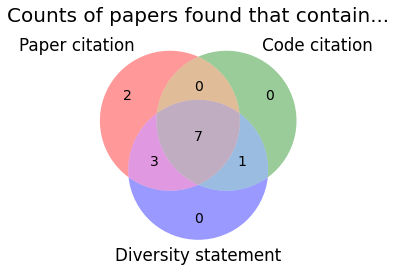

In [4]:
matplotlib.rc('font', **{'size': 14})

cols = ['paper_citation', 'code_citation', 'diversity_statement']
labels = [label.replace('_', ' ').capitalize() for label in cols]
venn_of_df(df[cols], labels=labels)
plt.title('Counts of papers found that contain...', fontsize=20)
plt.tight_layout()
plt.savefig('../../reports/figures/venn_diagram_content.png')

## Looking at where papers can be found
I did manual searches on Google Scholar for papers that cite the [code](https://scholar.google.com/scholar?cites=9664289398725956584&as_sdt=2005&sciodt=0,5&hl=en) and those that cite the [paper](https://scholar.google.com/scholar?cites=5476688246125765713&as_sdt=2005&sciodt=0,5&hl=en). 

I also did a search with opencitations.net to find DOIs of papers that cite the DOI of the [code](https://opencitations.net/index/coci/api/v1/citations/10.5281/zenodo.3672109) and the [paper](https://opencitations.net/index/coci/api/v1/citations/10.1101/2020.01.03.894378). 
The search for the code revealed 0 DOIs, so "Code opencitations" is not included in this diagram.

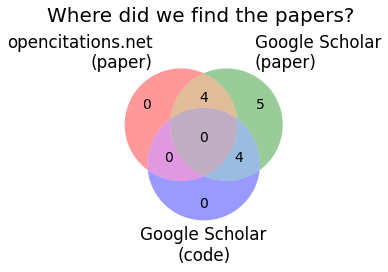

In [5]:
plt.figure()
matplotlib.rc('font', **{'size': 14})

cols = ['paper_opencitations',
 'paper_googlescholar',
 'code_googlescholar']
labels = ['opencitations.net\n(paper)',
          'Google Scholar\n(paper)',
          'Google Scholar\n(code)']
venn_of_df(df[cols], labels=labels)
plt.title('Where did we find the papers? \n', fontsize=20)
plt.tight_layout()
plt.savefig('../../reports/figures/venn_diagram_sources.png')

## Other interesting notes about the citing papers


In [6]:
print(f'{len(df)} papers were found')

print('%d papers contain a diversity statement' %df['diversity_statement'].sum())

n_preprints = df['preprint'].sum()
n_articles = len(df) - df['preprint'].sum()
print(f'{n_preprints} are preprints, {n_articles} journal articles')

n_by_bassett = df['bassett_author'].sum()
n_not_by_bassett = len(df) - n_by_bassett
print(f'{n_by_bassett} include Danielle Bassett as an author, {n_not_by_bassett} do not')

13 papers were found
11 papers contain a diversity statement
10 are preprints, 3 journal articles
10 include Danielle Bassett as an author, 3 do not


# Compare reported percentages to the benchmarks
Here, we extract the percentages reported in the citing papers' diversity statements, in order to visualize how they differ from the benchmarks reported in the original preprint. 

These are the possible labels for percentages listed in diversity statements. Which labels apply depends on how many percentages are given. Note that this may be inaccurate for some papers, but it's accurate for the papers in the current data (based on a manual check).

In [7]:
possible_labels = {
    4: ['mm', 'mw', 'wm', 'ww'],
    5: ['mm', 'mw', 'wm', 'ww', 'unknown'],
    6: ['mm', 'mw', 'wm', 'ww', 'nonbinary','unknown'],
    8: ['mm', 'mw', 'wm', 'ww',
        'rel_mm', 'rel_mw', 'rel_wm', 'rel_ww'],
    9: ['mm', 'mw', 'wm', 'ww',
        'rel_mm', 'rel_mw', 'rel_wm', 'rel_ww'],
    10: ['mm', 'mw', 'wm', 'ww', 'unknown',
        'rel_mm', 'rel_mw', 'rel_wm', 'rel_ww', 'rel_unknown'],
    11: ['mm', 'mw', 'wm', 'ww', 'nonbinary', 'unknown',
        'rel_mm', 'rel_mw', 'rel_wm', 'rel_ww', 'rel_unknown'],
}

Next, we the percentages in the diversity statement texts that were manually copied & pasted into the data table. 

We put the percentages in a dictionary with the labels corresponding to the number of percentages, and store this in the dataframe. 

In [8]:
pattern = '\−*\s*\d*.\d*\s*\%'
for n, text in enumerate(df['ds_text']):
    strs = re.findall(pattern, text)
    strs = [s.replace("−", "-") for s in strs]
    strs = [re.sub('[A-Za-z,]', '', s) for s in strs]

    ints = [float(s[:-1]) for s in strs]

    if len(ints) > 0:
        labels = possible_labels[len(ints)]
        d = dict(zip(labels, ints))
    else:
        d = {}
    df.loc[n, ('percentages')] = [d]

To prepare for making the figure, we list the percents reported in each diversity statement (not including the relative percentages or the 'non-binary' and 'other' categories, which weren't reported in each statement. 

In [9]:
lists_percents = {'mm': [],
                  'wm': [],
                  'mw': [],
                  'ww': [],
}

for d in df['percentages']:
    if len(d) > 0:
        for key in lists_percents.keys():
            lists_percents[key].append(d[key])

## Visualize the actual percentages

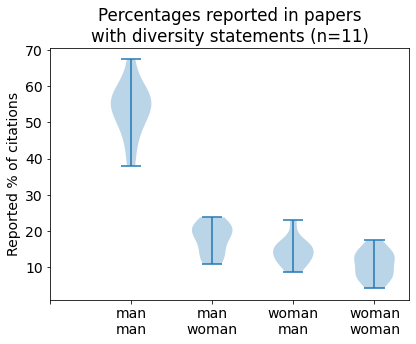

In [10]:
data_for_visualization = list(lists_percents.values())

matplotlib.rc('font', **{'size': 14})

fig, axes = plt.subplots(figsize=(6,5))
axes.violinplot(dataset=data_for_visualization)
axes.set_ylabel('Reported % of citations')
axes.set_xticks(range(len(lists_percents) + 1))
ticks = ['', 'man\nman', 'man\nwoman', 'woman\nman', 'woman\nwoman']
axes.set_xticklabels(ticks)
plt.title('Percentages reported in papers\n' +\
          f'with diversity statements (n=%d)' %df['diversity_statement'].sum())
plt.tight_layout()
plt.savefig('../../reports/figures/violinplot_percentages.png')

## Calculate and visualize the percentages relative to the benchmarks

In [11]:
expected_percentages = {'mm': 58.4,
                        'wm': 25.5,
                        'mw': 9.4,
                        'ww': 6.7,
}

lists_percent_diffs = {'mm': [],
                       'wm': [],
                       'mw': [],
                       'ww': [],
}

for d in df['percentages']:
    if len(d) > 0:
        for key in lists_percent_diffs.keys():
            diff = d[key] - expected_percentages[key]
            lists_percent_diffs[key].append(diff)


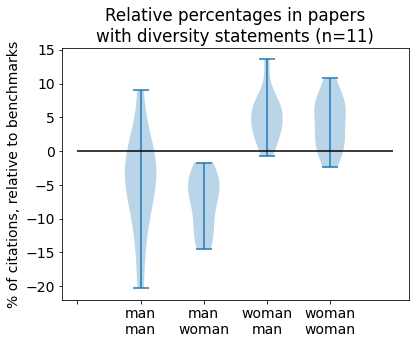

In [12]:
data_for_visualization = list(lists_percent_diffs.values())

matplotlib.rc('font', **{'size': 14})

fig, axes = plt.subplots(figsize=(6,5))
axes.violinplot(dataset=data_for_visualization)
axes.set_ylabel('% of citations, relative to benchmarks')
axes.set_xticks(range(len(lists_percents) + 1))
ticks = ['', 'man\nman', 'man\nwoman', 'woman\nman', 'woman\nwoman']
axes.set_xticklabels(ticks)
plt.title('Relative percentages in papers\n' +\
          f'with diversity statements (n=%d)' %df['diversity_statement'].sum())
plt.hlines(y=0, xmin=0, xmax=5)

plt.tight_layout()
plt.savefig('../../reports/figures/violinplot_percentage_diffs_from_benchmarks.png')